## Linear Hough

Import Libraries

In [30]:
import numpy as np
import cv2
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt

Initializing the accumulator

In [31]:
def initialize_accumulator(image_shape, theta_resolution=180):

    rows, cols = image_shape
    rho_max = int(round(np.sqrt(rows**2 + cols**2), 0))
    accumulator = np.zeros((2 * rho_max, theta_resolution), dtype=np.int32)
    return accumulator, rho_max

Finding the edge direction

In [32]:
def edge_direction(image_gradient_x, image_gradient_y):
    direction = np.arctan2(image_gradient_y, image_gradient_x)
    direction[direction < 0 ] += np.pi
    return direction

Using the Hough Transform pseudocode provided in the slides, implement the Hough Transform algorithm.

In [33]:
def hough_transform(edges, directions, threshold, theta_resolution=180):

    rows, cols = edges.shape
    accumulator, rho_max = initialize_accumulator(edges.shape, theta_resolution)
    for y in range(rows):
        for x in range(cols):
            if edges[y, x]:
                for theta in range(theta_resolution):
                    radian = np.deg2rad(theta)
                    if np.abs(np.cos(radian - directions[y, x])) > threshold:
                        rho = int(np.round(x * np.cos(radian) + y * np.sin(radian), 0))
                        accumulator[rho_max + rho, theta] += 1

    
    return accumulator

In [34]:
def find_local_maxima(accumulator, threshold):
    
    maxima = []
    for i in range(accumulator.shape[0]):# i is rho
        for j in range(accumulator.shape[1]):#j is theta
            if accumulator[i, j] >= threshold:
                if np.max(accumulator[max(i-1,0): i+2, max(j-1,0): j+2]) == accumulator[i, j]:
                    maxima.append((i ,j))

    return maxima

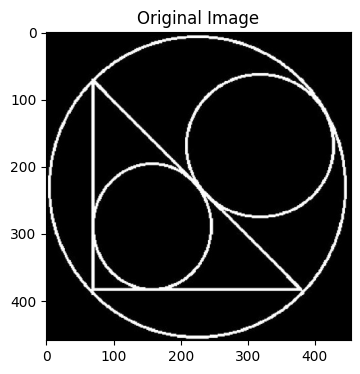

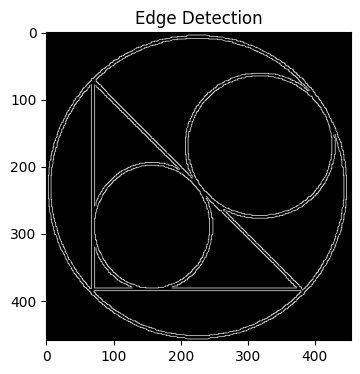

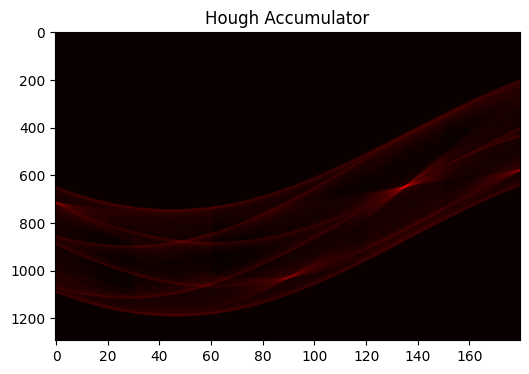

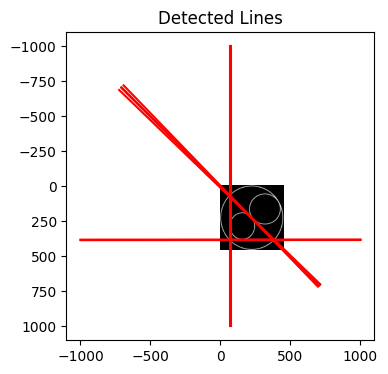

In [35]:
def process_image(image_path, edge_threshold=50, hough_threshold=120):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(6, 4))  
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.show()  
    
    edges = cv2.Canny(image, edge_threshold, edge_threshold * 2)
    plt.figure(figsize=(6, 4))  
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.show() 
    
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    directions = edge_direction(gradient_x, gradient_y)
    
    accumulator = hough_transform(edges, directions, threshold=0.5)
    plt.figure(figsize=(6, 4))  
    plt.imshow(accumulator, cmap='hot', aspect='auto')
    plt.title('Hough Accumulator')
    plt.show()  
    
    maxima = find_local_maxima(accumulator, hough_threshold)
    plt.figure(figsize=(6, 4))  
    plt.imshow(image, cmap='gray')
    
    for rho, theta in maxima:
        theta_rad = np.deg2rad(theta * (180 / accumulator.shape[1]))
        a = np.cos(theta_rad)
        b = np.sin(theta_rad)
        x0 = a * (rho - accumulator.shape[0] // 2)
        y0 = b * (rho - accumulator.shape[0] // 2)
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        plt.plot([x1, x2], [y1, y2], 'r')
    plt.title('Detected Lines')
    plt.show()  

img_path = 'linear_hough.JPG'
process_image(img_path)

## Circle Hough

In this section, we have an image containing several circles. We want to identify the circular shapes in the image, calculate their areas, and determine which shapes contain holes. Complete the required parts to achieve the desired output.

Import Libraries

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [37]:
def load_image(image_path):
    
    image = cv2.imread(image_path, 0) 
    
    return image

Smooth the image.

In [38]:
def preprocess_image(image):
    
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    
    return blur


Binarize the image

In [39]:
def apply_threshold(blur, threshold_value=128, max_value=255):
    
    _, thresh = cv2.threshold(blur, threshold_value, max_value, cv2.THRESH_BINARY)
    
    return thresh

Note: You can use the Library functions to apply the Hough transform.

In [40]:
def detect_circles(blur):

    circles = cv2.HoughCircles(
    blur,
    cv2.HOUGH_GRADIENT,
    dp=1,  # Inverse ratio of resolution
    minDist=35,  # Minimum distance between detected centers
    param1=50,  # Upper threshold for the Canny edge detector
    param2=30,  # Threshold for center detection
    minRadius=30,  # Minimum radius of the circle
    maxRadius=70   # Maximum radius of the circle
)
    
    return circles

In [41]:
def process_circles(image, circles, blur, thresh):
    
    circles = np.round(circles[0, :]).astype("int")
    
    for i, (x, y, r) in enumerate(circles):
        cv2.circle(image, (x, y), r, (0, 255, 0), 2)
        cv2.putText(
            image, 
            str(i+1), 
            (x-r, y+4),
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.8, 
            (0, 0, 255), 
            2
        )
        
        theoretical_area = math.pi * r * r
        
        circle_mask = np.zeros(blur.shape, dtype=np.uint8)
        cv2.circle(circle_mask, (x, y), r, 255, -1)
        circle_img = cv2.bitwise_and(thresh, circle_mask)
        actual_area = cv2.countNonZero(circle_img)
        
        if abs(theoretical_area - actual_area) > 220:
            print(f"Circle {i+1} with radius {r} \033[0;31;40mhas a hole\033[0m")
        
        print(f"Circle {i+1} with radius {r} has area {actual_area:.2f} (theoretical: {theoretical_area:.2f})")
    
    return image

In [42]:
def display_image(image, output_path='Image.JPG'):
   
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8)) 
    plt.imshow(image_rgb)
    plt.axis('off')  
    plt.title('Processed Image')  
    plt.show()


Circle 1 with radius 51 has area 8062.00 (theoretical: 8171.28)
Circle 2 with radius 60 has area 11266.00 (theoretical: 11309.73)
Circle 3 with radius 61 has area 11526.00 (theoretical: 11689.87)
Circle 4 with radius 44 has area 6058.00 (theoretical: 6082.12)
Circle 5 with radius 64 has a hole
Circle 5 with radius 64 has area 12485.00 (theoretical: 12867.96)
Circle 6 with radius 50 has area 7822.00 (theoretical: 7853.98)
Circle 7 with radius 51 has area 8069.00 (theoretical: 8171.28)
Circle 8 with radius 45 has a hole
Circle 8 with radius 45 has area 5324.00 (theoretical: 6361.73)
Circle 9 with radius 56 has area 9662.00 (theoretical: 9852.03)
Circle 10 with radius 44 has area 6070.00 (theoretical: 6082.12)
Circle 11 with radius 55 has a hole
Circle 11 with radius 55 has area 8915.00 (theoretical: 9503.32)
Circle 12 with radius 56 has a hole
Circle 12 with radius 56 has area 9343.00 (theoretical: 9852.03)
Circle 13 with radius 50 has a hole
Circle 13 with radius 50 has area 7245.00 (th

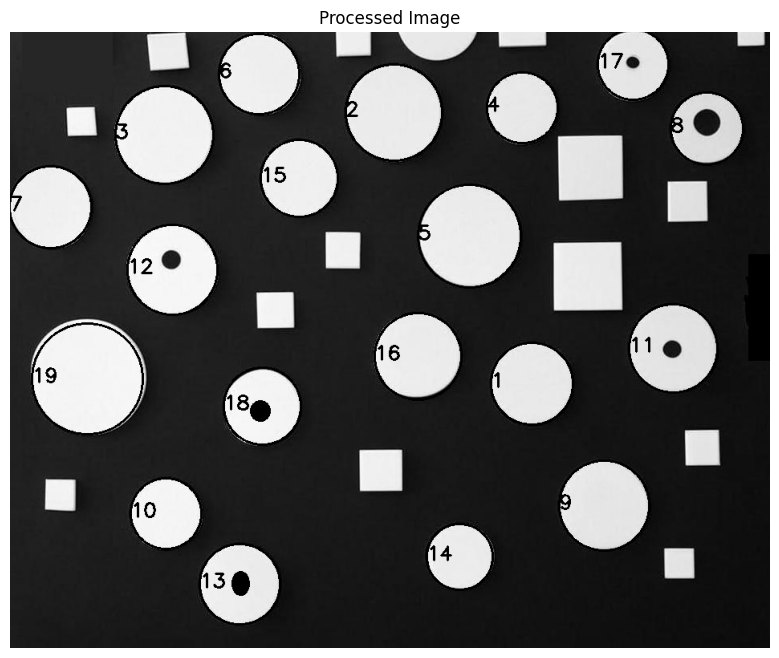

In [43]:
def main():
    image_path = "circle_hough.jpg"
    image = load_image(image_path)
    blur = preprocess_image(image)
    thresh = apply_threshold(blur)
    circles = detect_circles(blur)
    result_image = process_circles(image, circles, blur, thresh)
    display_image(result_image)

if __name__ == "__main__":
    main()